### 回调实现者的类
fastai提供了一个强大的回调系统，它记录在回调页面上;如果您只是在寻找如何使用现有的回调，请查看该页面。如果你想创建自己的，你需要使用下面讨论的类。

回调系统的一个关键动机是，可以在单个回调中完全实现附加功能，以便轻松读取。通过使用这个技巧，我们将有不同的方法分类在不同的回调中，我们将清楚地说明该方法在训练中所做的所有干预。例如在LRFinder回调中，除了使用指数增长的LR运行fit函数之外，它还需要处理一些准备和清理，所有这些代码都可以在同一个回调中，因此我们确切知道它在做什么以及在哪里看看我们是否需要改变一些东西。

此外，它使我们的贴合功能非常干净和简单，但仍然可以轻松扩展。到目前为止，在实施一些最近的论文时，我们尚未遇到任何我们必须修改训练循环源代码的情况 - 我们每次都能够使用回调。

<b>class Callback</b>

`Callback()`

想要记录值，动态改变学习者参数等的回调的基类。

要创建新类型的回调，您需要从此类继承，并根据需要实现一个或多个方法。 或许最简单的入门方法是查看一些预定义的fastai回调的源代码。 你可能会对它们的简单程度感到惊讶！ 例如，以下是GradientClipping的完整源代码：

```python
@dataclass
class GradientClipping(LearnerCallback):
    clip:float
    def on_backward_end(self, **kwargs):
        if self.clip:
            nn.utils.clip_grad_norm_(self.learn.model.parameters(), self.clip)
```

您通常希望自定义回调构造函数采用Learner参数，例如：

```python
@dataclass
class MyCallback(Callback):
    learn:Learner
```

请注意，这允许回调用户在构造他们的学习者时将回调名称传递给callback_fns，因为在从callback_fns构造回调时，它总是通过self。 此外，通过传递学习者，这个回调将可以访问所有内容：例如计算所有输入/输出，损失，以及数据加载器，优化器等。随时：
* 更改self.learn.data.train_dl或self.data.valid_dl将在fit函数内更改它们（我们只需要将DataBunch对象传递给fit函数而不是data.train_dl / data.valid_dl）
* 更改self.learn.opt.opt（我们在实际优化器之上有一个OptimWrapper）将在fit函数内更改它。
* 直接更改self.learn.data或self.learn.opt不会更改fit函数内的数据或优化器。

在任何回调中，您可以在kwargs中解压缩：
* `n_epochs`，包含训练将总共采用的时期数
* `epoch`，包含当前的数量
* `iteration`，包含自训练开始以来完成的迭代次数
* `num_batch`，包含我们在dataloader中的批次编号
* `last_input`，包含通过模型的最后一个输入（最终由回调更新）
* `last_target`，包含通过模型的最后一个目标（最终由回调更新）
* `last_output`，包含模型吐出的最后一个输出（最终由回调更新）
* `last_loss`，包含最后计算的损失（最终由回调更新）
* `smooth_loss`，包含损失的平滑版本
* `last_metrics`，包含最后的验证损失和计算的指标
* `pbar`，进度条
* `train`，标志我们是否处于训练模式
* `stop_training`，如果为True，将在当前纪元结束时停止训练
* `stop_epoch`，将打破当前的纪元循环
* `skip_step`，将跳过下一个优化器步骤
* `skip_zero`，将跳过下一个零毕业

返回带有这些键名的字典时，CallbackHandler的状态将使用任何这些更改进行更新，因此在任何Callback中，您都可以更改这些值。

### 您的子类可以实现的方法
所有这些方法都是可选的; 你的子类可以根据需要处理多少个。

<b>on_train_begin</b>

`on_train_begin(**kwargs:Any)`

初始化回调中的常量。
在这里我们可以初始化我们需要的任何东 优化器尚未初始化。 我们可以通过键入来更改任何超参数，例如：

```python
self.opt.lr = new_lr
self.opt.mom = new_mom
self.opt.wd = new_wd
self.opt.beta = new_beta
```

<b>on_epoch_begin</b>

`on_epoch_begin(**kwargs:Any)`

在每个`epoch`的开始。

这在技术上并不需要，因为我们为所有其他时期都有on_train_begin用于`epoch`0和on_epoch_end，但它使得编写需要在每个`epoch`开始时完成的代码变得容易且更易读。

<b>on_batch_begin</b>

`on_batch_begin(**kwargs:Any)`

在计算输出和损耗之前设置HP。

这是在模型调用之前准备好一切的完美场所。 示例：更改超参数的值（如果我们不改为on_batch_end）

在该事件xb的末尾，yb将被设置为CallbackHandler状态的last_input，last_target。

<b>on_loss_begin</b>

`on_loss_begin(**kwargs:Any)`

在向前通过之后但在计算损失之前调用。

这里是运行一些代码的地方，这些代码需要在计算输出之后但在丢失计算之前执行。 示例：在混合精度训练时将输出放回FP32。

在该事件结束时，输出将被设置为CallbackHandler状态的last_output。

<b>on_backward_begin</b>

`on_backward_begin(**kwargs:Any)`

在正向传球之后调用并且计算了损失，但是在backprop之前。

这里是运行一些代码的地方，这些代码需要在计算损失之后但在梯度计算之前执行。 示例：RNN中的reg_fn。

在该事件结束时，输出将被设置为CallbackHandler状态的last_loss。

<b>on_backward_end</b>

`on_backward_end(**kwargs:Any)`

在backprop之后但在优化步骤之前调用。 对于AdamW的真正体重衰减很有用。

这里是运行一些代码的地方，这些代码需要在计算梯度之后但在调用优化器之前执行。

如果在此事件结束时skip_step为True，则跳过优化程序步骤。

<b>on_step_end</b>

`on_step_end(**kwargs:Any)`

在优化器的步骤之后但在渐变为零之前调用。

这里是运行一些代码的地方，这些代码需要在优化器步骤之后但在梯度归零之前执行。

如果在此事件结束时skip_zero为True，则渐变不会归零。

<b>on_batch_end</b>

`on_batch_end(**kwargs:Any)`

在批次结束时调用。

以下是运行完全完成批处理后需要执行的代码的地方。 示例：更改超参数的值（如果我们不改为on_batch_begin）

如果在此事件结束时end_epoch为True，则当前纪元被中断（例如：lr_finder在损失爆炸时停止训练）。

<b>on_epoch_end</b>

`on_epoch_end(**kwargs:Any)`

在一个`epoch`结束时被召唤。

这是运行一些需要在`epoch`结束时执行的代码的地方。 示例：如果我们有新的最佳验证损失/指标，请保存模型。

如果在此事件结束时end_training为True，则训练停止（例如：提前停止）。

<b>on_train_end</b>

`on_train_end(**kwargs:Any)`

用于清理和保存文件/模型。

这里是整理所有东西的地方。 即使在训练循环期间出现错误，它也总是被执行，并且有一个额外的kwarg命名异常来检查是否存在异常。 示例：保存log_files，加载训练期间找到的最佳模型

<b>get_state</b>

`get_state(minimal:bool=True)`

返回Callback的内部状态，最小化与否。

这在尝试导出学习者时在内部使用。 您不需要对此函数进行子类化，但您可以将属性名称添加到您正在设计的回调列表中的exclude或not_minof。 exclude中的属性永远不会保存，not_min中的属性仅在minimal = False时保存。

### 退火功能
以下功能提供不同的退火时间表。 您可能不需要直接调用它们，而是将它们用作回调的一部分。 以下是每个人的样子：
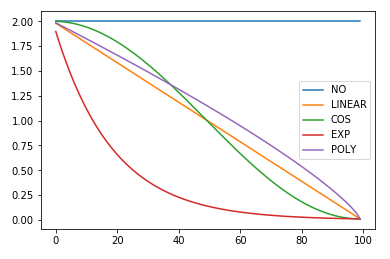

<b>annealing_cos</b>

`annealing_cos(start:Number, end:Number, pct:float) → Number`

当pct从0.0变为1.0时，余弦从开始到结束退火。

<b>annealing_exp</b>

`annealing_exp(start:Number, end:Number, pct:float) → Number`

当pct从0.0变为1.0时，从开始到结束呈指数退火。

<b>annealing_linear</b>

`annealing_linear(start:Number, end:Number, pct:float) → Number`

当pct从0.0变为1.0时，从开始到结束进行线性退火。

<b>annealing_no</b>

`annealing_no(start:Number, end:Number, pct:float) → Number`

没有退火，总是返回开始。

<b>annealing_poly</b>

`annealing_poly(degree:Number) → Number`

当pct从0.0变为1.0时，从开始到结束以多项式退火。

## class CallbackHandler

`CallbackHandler(callbacks:Collection[Callback]=None, metrics:Collection[Callback]=None, beta:float=0.98)`

管理所有已注册的回调和指标，通过动量beta平滑损失。

您可能不需要自己使用此课程。 fastai使用它将所有回调组合在一起，并为每个训练阶段调用任何相关的回调函数。 下面的方法只是在self.callbacks中的每个回调函数中调用等效方法。

<b>on_backward_begin</b>

`on_backward_begin(loss:Tensor) → Tuple[Any, Any]`

处理损失时的梯度计算。

<b>on_backward_end</b>

`on_backward_end() → Any`

处理梯度计算结束。

<b>on_batch_begin</b>

`on_batch_begin(xb:Tensor, yb:Tensor, train:bool=True) → Tuple[Any, Any]`

在train或validation.中处理新的批次xb，yb。

<b>on_batch_end</b>

`on_batch_end(loss:Tensor) → Any`

处理一批Loss处理结束。

<b>on_epoch_begin</b>

`on_epoch_begin()`

处理新`epoch`。

<b>on_epoch_end</b>

`on_epoch_end(val_loss:Tensor) → bool`

Epoch完成, 处理val_loss.

<b>on_loss_begin</b>

`on_loss_begin(out:Tensor) → Any`

处理模型输出输出的损失计算开始。

<b>on_step_end</b>

`on_step_end() → Any`

处理优化步骤的结束。

<b>on_train_begin</b>

`on_train_begin(epochs:int, pbar:PBar, metrics:MetricFuncList)`

即将开始学习。

<b>on_train_end</b>

`on_train_end(exception:Union[bool, Exception])`

处理训练结束，如果在训练期间没有例外，则例外是例外或假。

<b>set_dl</b>

`set_dl(dl:DataLoader)`

设置当前使用的dl。

## class OptimWrapper
`OptimWrapper(opt:Optimizer, wd:Floats=0.0, true_wd:bool=False, bn_wd:bool=True)`

基本包装选择简化超参数更改。

这是一个便利类，它提供了一致的API来获取和设置优化器超参数。 例如，对于optim.Adam，动量参数实际上是beta[0]，而对于optim.SGD，它只是动量。 另一个例子，处理权重衰减的细节取决于您使用的是true_wd还是传统的L2正则化方法。

该类还处理为每个层组设置不同的WD和LR，用于判别层训练。

<b>clear</b>

`clear()`

重置内部优化器的状态。

<b>create</b>

`create(opt_func:Union[type, Callable], lr:Union[float, Tuple, List[T]], layer_groups:ModuleList, wd:Floats=0.0, true_wd:bool=False, bn_wd:bool=True) → Optimizer`

使用lr从opt_func创建optim.Optimizer。 在layer_groups上设置lr。

<b>new</b>

`new(layer_groups:ModuleList, split_no_wd:bool=True)`

从self创建一个新的OptimWrapper与另一个layer_groups但相同的超参数。

<b>read_defaults</b>

`read_defaults()`

读取优化器内部的值以获取超参数。

<b>read_val</b>

`read_val(key:str) → Union[List[float], Tuple[List[float], List[float]]]`

读取优化程序字典中的超参数键。

<b>set_val</b>

`set_val(key:str, val:Any, bn_groups:bool=True) → Any`

在key处设置优化器字典中的val。

<b>step</b>

`step()`

设置重量衰减和步骤优化器。

<b>zero_grad</b>

`zero_grad()`

清除优化器渐变。

## class SmoothenValue
`SmoothenValue(beta:float)`

使用beta为值（损失等）创建平滑移动平均值。

用于记录器中的平滑损失。

<b>add_value</b>

`add_value(val:float)`

添加val以计算更新的平滑值。

## class Scheduler
`Scheduler(vals:StartOptEnd, n_iter:int, func:Optional[AnnealFunc]=None)`

用于按照func定义的时间表从n_iter迭代开始，结束（vals）“步进”

用于创建退火计划，主要用于OneCycleScheduler。

<b>step</b>

`step() → Number`

沿退火计划返回下一个值。

## class AverageMetric
`AverageMetric(func) :: Callback`

在回调中包装func以进行度量计算。

有关更多信息，请参阅有关指标的文档。

回调方法
你不要自己调用 - 他们会被fastai的Callback系统自动调用，以启用该类的功能。

<b>on_epoch_begin</b>

`on_epoch_begin(**kwargs)`

将内部值设置为0。

<b>on_batch_end</b>

`on_batch_end(last_output, last_target, **kwargs)`

使用last_output和last_target更新度量计算。

<b>on_epoch_end</b>

`on_epoch_end(last_metrics, **kwargs)`

在last_metrics中设置最终结果。